# Revenue Modeling: RTT

**Purpose:** This notebook models realty transfer tax revenue by modeling number of sales and price per sale for residential and non-residential sectors. 


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from phila_style.core import *
from phila_style.matplotlib import get_theme

In [58]:
# Prediction functions
from fyp_analysis.pipelines.modeling.predict import (
    plot_projection_comparison,
    get_forecasts_from_fits,
    aggregate_to_fiscal_year
)

from fyp_analysis.extras.datasets import load_cbo_data, Taxes

In [6]:
pd.options.display.max_columns = 999

In [7]:
palette = get_default_palette()

In [8]:
TAX_NAME = "RTT"
TAX_BASE_COLUMN = f"{TAX_NAME}Base"

In [90]:
%reload_kedro

2022-07-08 13:35:37,591 - kedro.extras.extensions.ipython - INFO - No path argument was provided. Using: /Users/nicholashand/LocalWork/Analysis/five-year-plan-analysis
2022-07-08 13:35:38,092 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2022-07-08 13:35:38,311 - kedro.extras.extensions.ipython - INFO - ** Kedro project Five Year Plan Analysis
2022-07-08 13:35:38,313 - kedro.extras.extensions.ipython - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`


## Parameter Setup

Set up the data catalog. We can use `DATA.load()` to load specific data instances.

In [91]:
DATA = context.catalog

Available data:

In [92]:
DATA.list()

['economic_indicators',
 'quarterly_features_raw',
 'quarterly_features_cbo_imputed',
 'features_and_bases',
 'features_and_bases_sa',
 'stationary_guide',
 'final_unscaled_features',
 'final_scaled_features',
 'scaled_feature_correlations',
 'grangers_matrix',
 'possible_endog_variables',
 'plan_details',
 'wage_fit_params',
 'sales_fit_params',
 'net_income_fit_params',
 'gross_receipts_fit_params',
 'rtt_fit_params',
 'rtt_tax_base_forecast',
 'parking_fit_params',
 'amusement_fit_params',
 'npt_fit_params',
 'tax_base_forecasts',
 'tax_revenue_forecasts',
 'parameters',
 'params:fresh_indicators',
 'params:seasonal_adjustments',
 'params:min_feature_year',
 'params:max_fit_date',
 'params:grangers_maxlag',
 'params:grangers_max_date',
 'params:forecast_types',
 'params:forecast_types.wage',
 'params:forecast_types.sales',
 'params:forecast_types.net_income',
 'params:forecast_types.gross_receipts',
 'params:forecast_types.parking',
 'params:forecast_types.amusement',
 'params:forec

Load the parameter dict too:

In [53]:
PARAMS = context.params

In [54]:
PARAMS

{'fresh_indicators': False,
 'seasonal_adjustments': ['ActivityLicensesPhilly',
  'BizLicensesPhilly',
  'BuildingPermitsPhilly',
  'CPIPhillyMSA',
  'ContinuedClaimsPA',
  'WeeklyEconomicIndex',
  'DeedTransfersPhilly',
  'InitialClaimsPA',
  'UncertaintyIndex',
  'UnemploymentPhilly'],
 'min_feature_year': 1996,
 'max_fit_date': '2022-06-30',
 'grangers_maxlag': 6,
 'grangers_max_date': '2019-12-31',
 'plan_start_year': 2023,
 'cbo_forecast_date': 'latest'}

Extract specific parameters:

In [55]:
# Trim features to this start year
min_year = PARAMS["min_feature_year"]

# When is the CBO forecast from?
cbo_forecast_date = PARAMS["cbo_forecast_date"]

# First fiscal year of the plan
plan_start_year = PARAMS["plan_start_year"]

## Data Setup

Load taxes object responsible for loading historical tax data"

In [59]:
# Load the Plan details we are using
plan_details = DATA.load("plan_details")

# All taxes
all_taxes = Taxes(plan_details)

# This tax
this_tax = all_taxes[TAX_NAME]

2022-07-08 13:01:41,865 - kedro.io.data_catalog - INFO - Loading data from `plan_details` (PlanDetailsYAMLDataSet)...


## 1. Data Processing

### Load RTT data

In [10]:
rtt = pd.read_csv(
    "../../data/01_raw/historical/rtt/rtt_summary.csv",
    dtype={"opa_account_num": str},
)

/var/folders/n4/d05s5jdd7pn_v955k5trnt5h0000gn/T/ipykernel_236/1660995624.py:1: DtypeWarning: Columns (26,34,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  rtt = pd.read_csv(


In [11]:
for col in ["display_date", "recording_date", "receipt_date"]:
    rtt[col] = pd.to_datetime(rtt[col])

In [12]:
deeds = (
    rtt.loc[
        rtt["document_type"].isin(
            [
                "DEED",
                "DEED SHERIFF",
                "DEED MISCELLANEOUS TAXABLE",
                "CERTIFICATE OF STOCK TRANSFER",
            ]
        )
    ]
    .sort_values("opa_account_num")
    .drop_duplicates(subset=["document_id"])
)

#### Load OPA data

In [13]:
opa = pd.read_csv(
    "../..//data/01_raw/historical/rtt/opa_properties_public.csv",
    dtype={"parcel_number": str},
)

/var/folders/n4/d05s5jdd7pn_v955k5trnt5h0000gn/T/ipykernel_236/1177213244.py:1: DtypeWarning: Columns (4,11,12,21,25,30,42,48,54,60,67,69,71) have mixed types. Specify dtype option on import or set low_memory=False.
  opa = pd.read_csv(


In [14]:
opa["category_code_description"].value_counts()

Single Family    463109
Vacant Land       43279
Multi Family      42522
Mixed Use         14344
Commercial        13993
Industrial         4316
Name: category_code_description, dtype: int64

### Merge

In [15]:
X = deeds.merge(
    opa[
        [
            "parcel_number",
            "category_code_description",
            "category_code",
            "building_code_description",
        ]
    ],
    left_on="opa_account_num",
    right_on="parcel_number",
    how="left",
).assign(parcel_type=lambda df: df.parcel_number.str.slice(0, 3))


pattern = "|".join([f"{x:02d}" for x in range(1, 77)]) + "|888|881"
residential_sel = (
    X["parcel_type"].str.match(f"^({pattern})", na=False) | X["parcel_number"].isnull()
)

residential = X.loc[residential_sel]
nonresidential = X.loc[~residential_sel]

In [16]:
def get_data(df):

    g = df.drop_duplicates(subset=["document_id"]).groupby(
        pd.Grouper(key="recording_date", freq="QS")
    )
    return (
        pd.concat(
            [
                g.size().rename("num_records"),
                g["local_tax_amount"].sum().rename("total"),
            ],
            axis=1,
        )
        .assign(total_per_record=lambda df: df.total / df.num_records)
        .rename_axis("date", axis=0)
        .reset_index()
    )

In [18]:
# Get the data
tot = get_data(X).iloc[1:]
res = get_data(residential).iloc[1:].set_index("date")
nonres = get_data(nonresidential).iloc[1:].set_index("date")


# Set FY22 Q3 values from Revenue Report
res.loc["2022-01-01", ["num_records", "total", "total_per_record"]] = [
    15890,
    135068715,
    135068715 / 15890,
]

nonres.loc["2022-01-01", ["num_records", "total", "total_per_record"]] = [
    922, 60744767, 60744767/922
]

res = res.reset_index()
nonres = nonres.reset_index()

### Totals

In [19]:
# Total by quarter
total = nonres.set_index("date")["total"] + res.set_index("date")["total"]

total / 1e6

date
2000-01-01     13.667216
2000-04-01     18.580572
2000-07-01     14.783675
2000-10-01     17.334120
2001-01-01     12.467969
                 ...    
2021-01-01     62.072216
2021-04-01     79.557078
2021-07-01     60.847199
2021-10-01    137.514524
2022-01-01    195.813482
Name: total, Length: 89, dtype: float64

In [20]:
# Total by fiscal year
def get_fy_total(df):
    
    total_fy = df.copy().reset_index()
    total_fy["fiscal_year"] = [dt.year for dt in df.index.shift(2, freq="QS")]
    return total_fy.groupby("fiscal_year").sum()

In [21]:
get_fy_total(total)/1e6

,total
fiscal_year,
2000,32.247788
2001,60.516027
2002,69.283094
2003,80.924061
2004,121.887565
2005,159.550459
2006,207.156487
2007,211.448052
2008,182.412789


## Residential

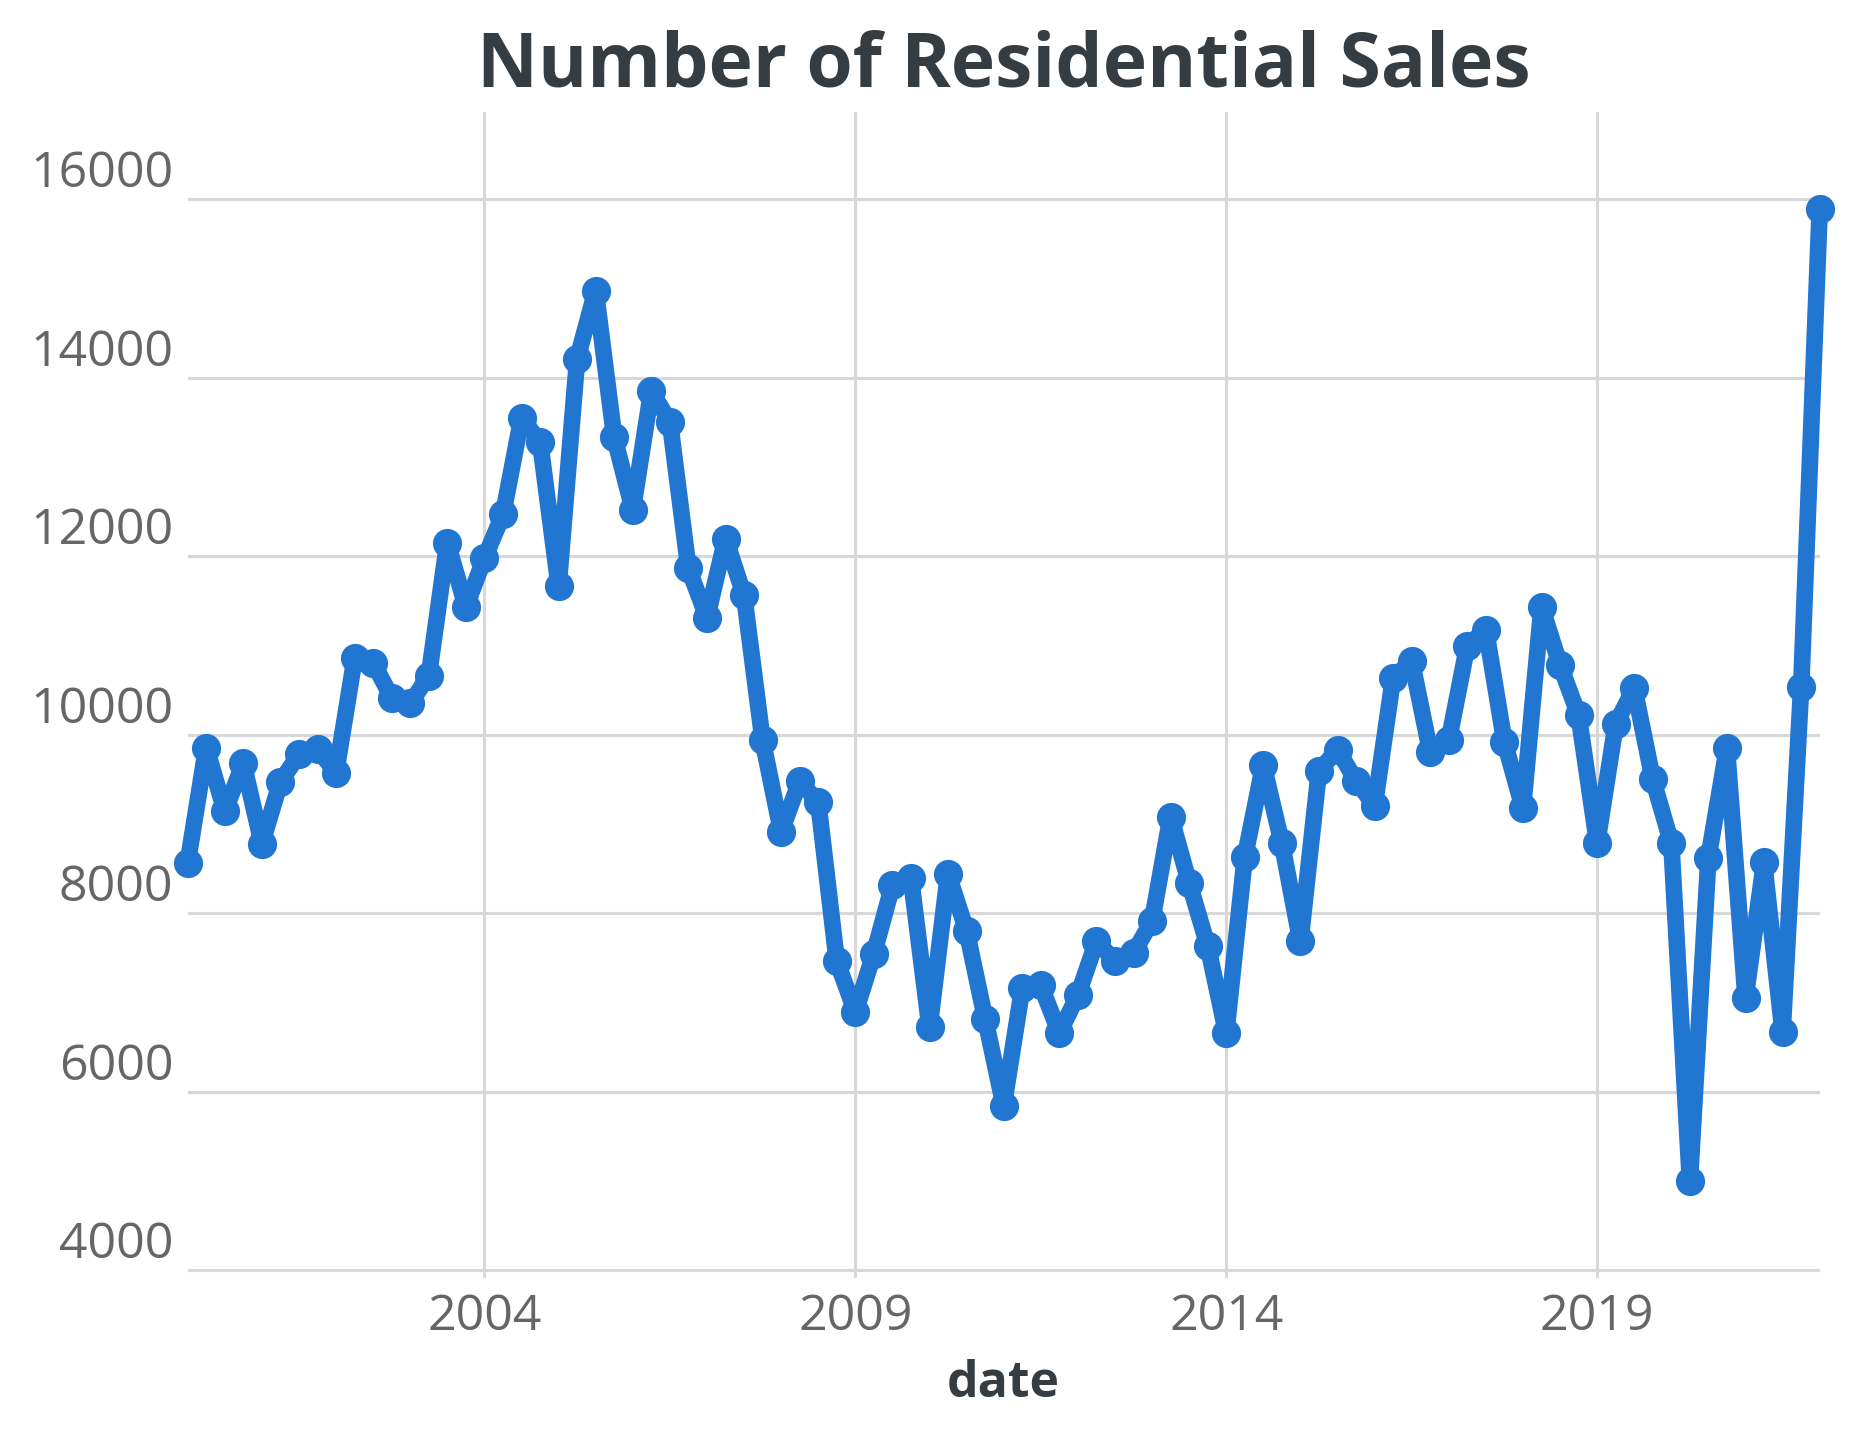

In [23]:
with plt.style.context(get_theme()):
    ax = res.plot(x="date", y="num_records", legend=False, clip_on=False, marker="o")
    ax.set_title("Number of Residential Sales")

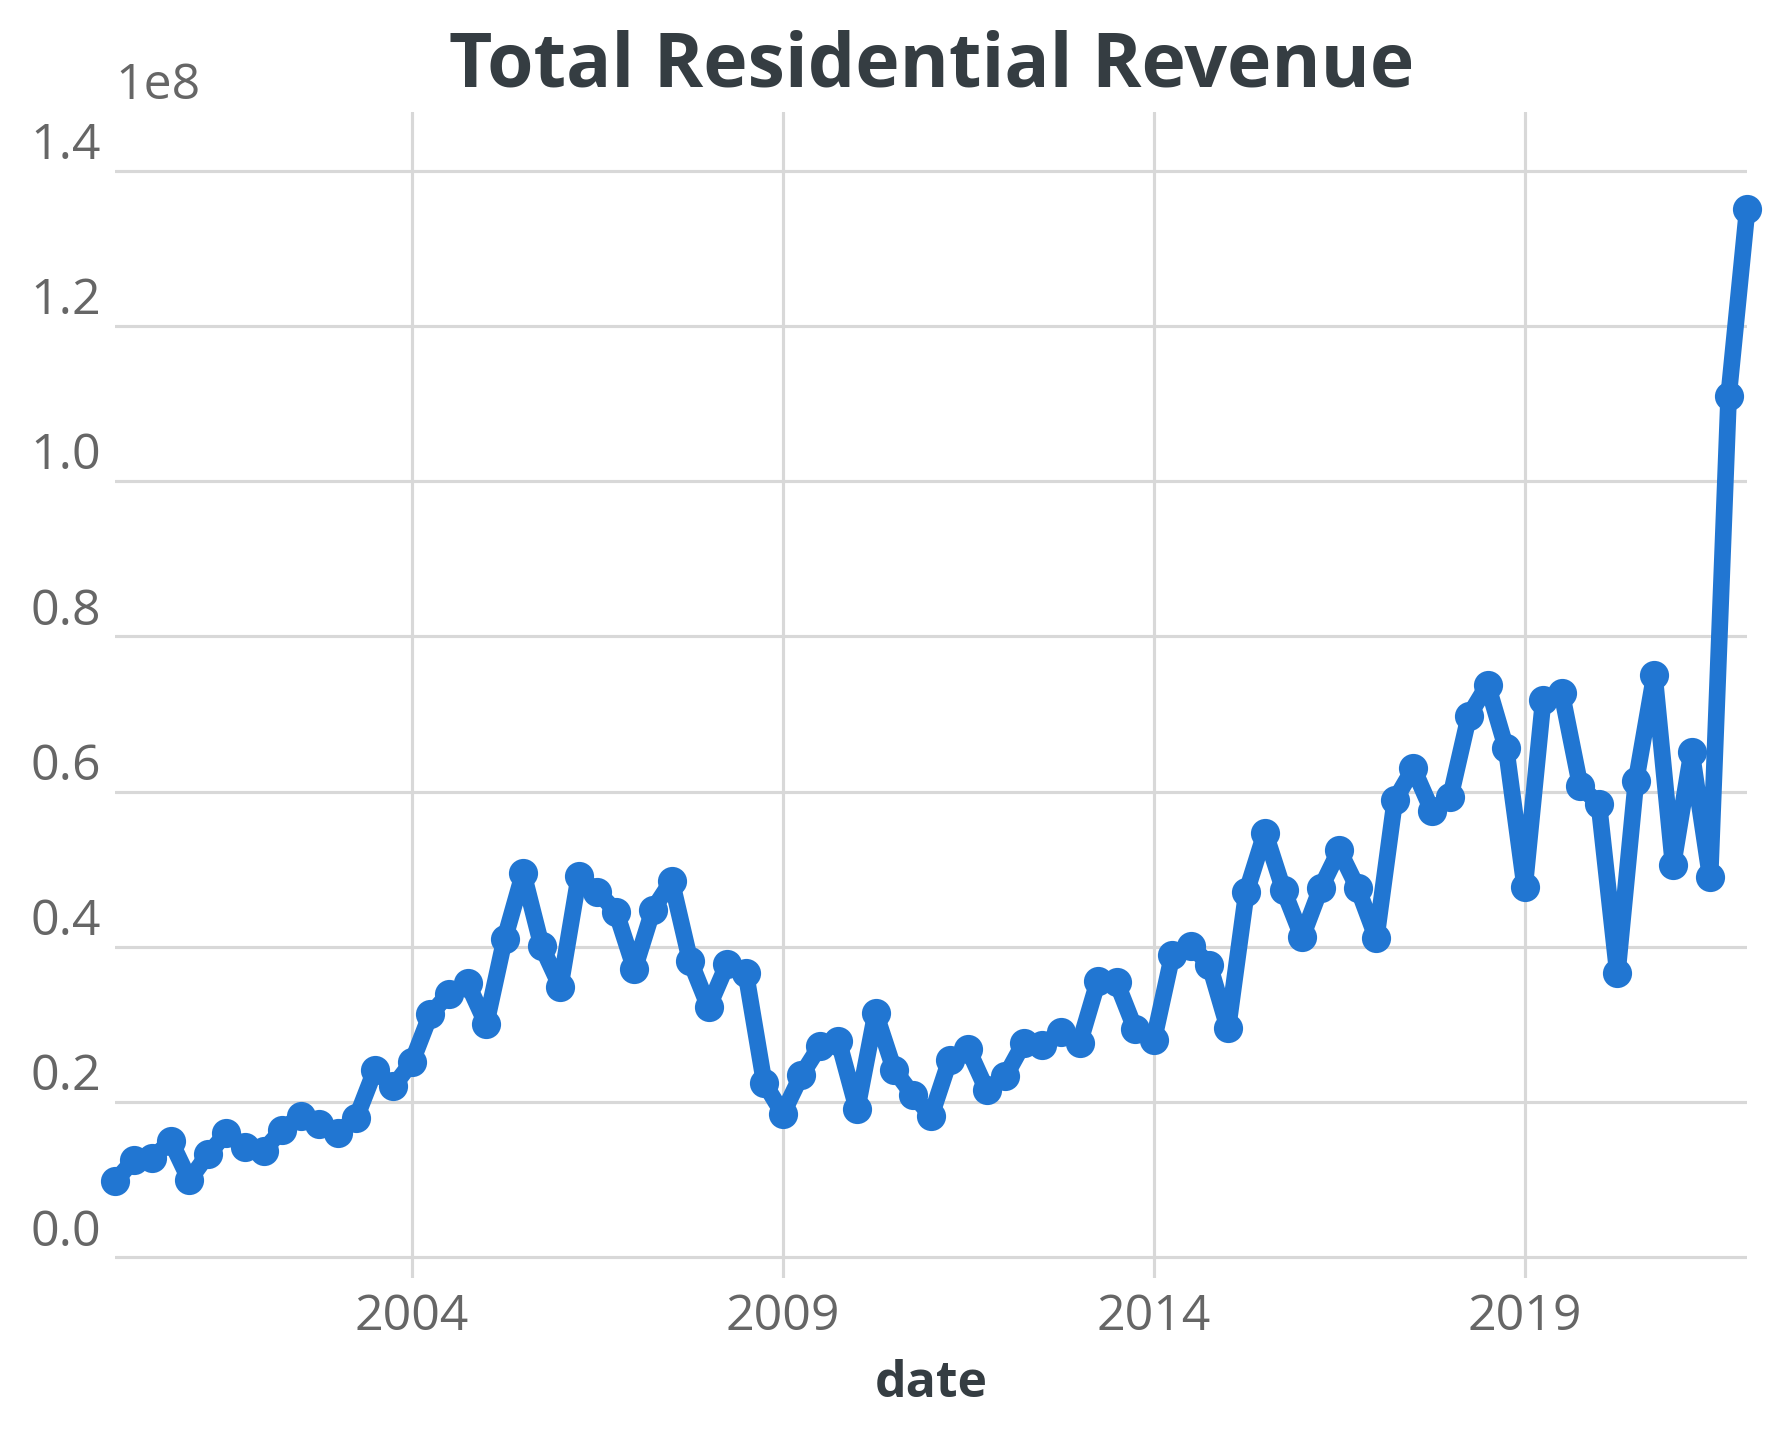

In [24]:
with plt.style.context(get_theme()):
    ax = res.plot(x="date", y="total", legend=False, clip_on=False, marker="o")
    ax.set_title("Total Residential Revenue")

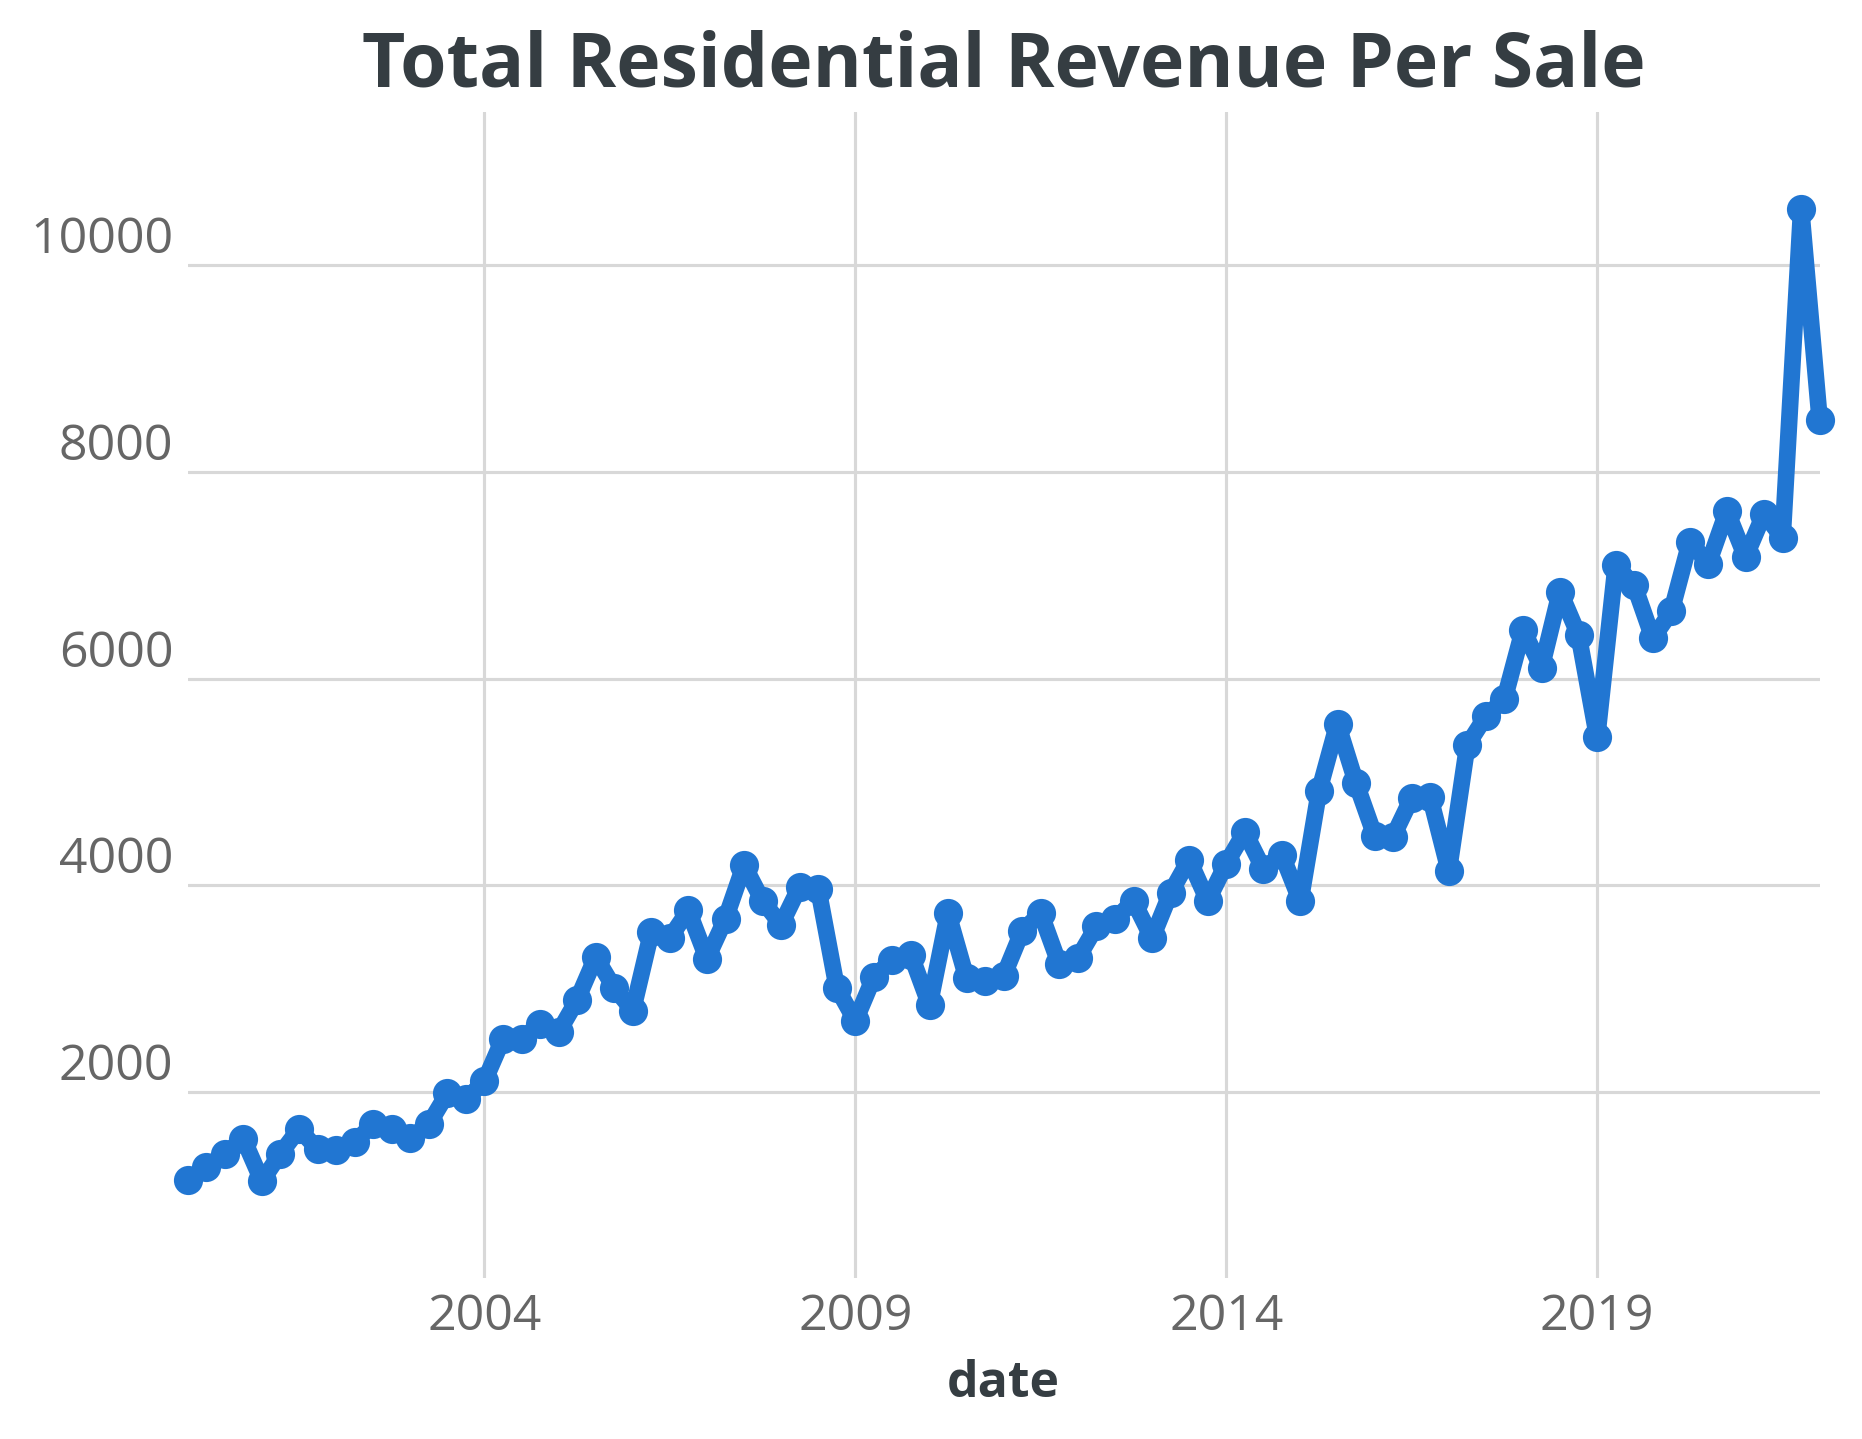

In [25]:
with plt.style.context(get_theme()):
    ax = res.plot(
        x="date", y="total_per_record", legend=False, clip_on=False, marker="o"
    )
    ax.set_title("Total Residential Revenue Per Sale")

## Nonresidential

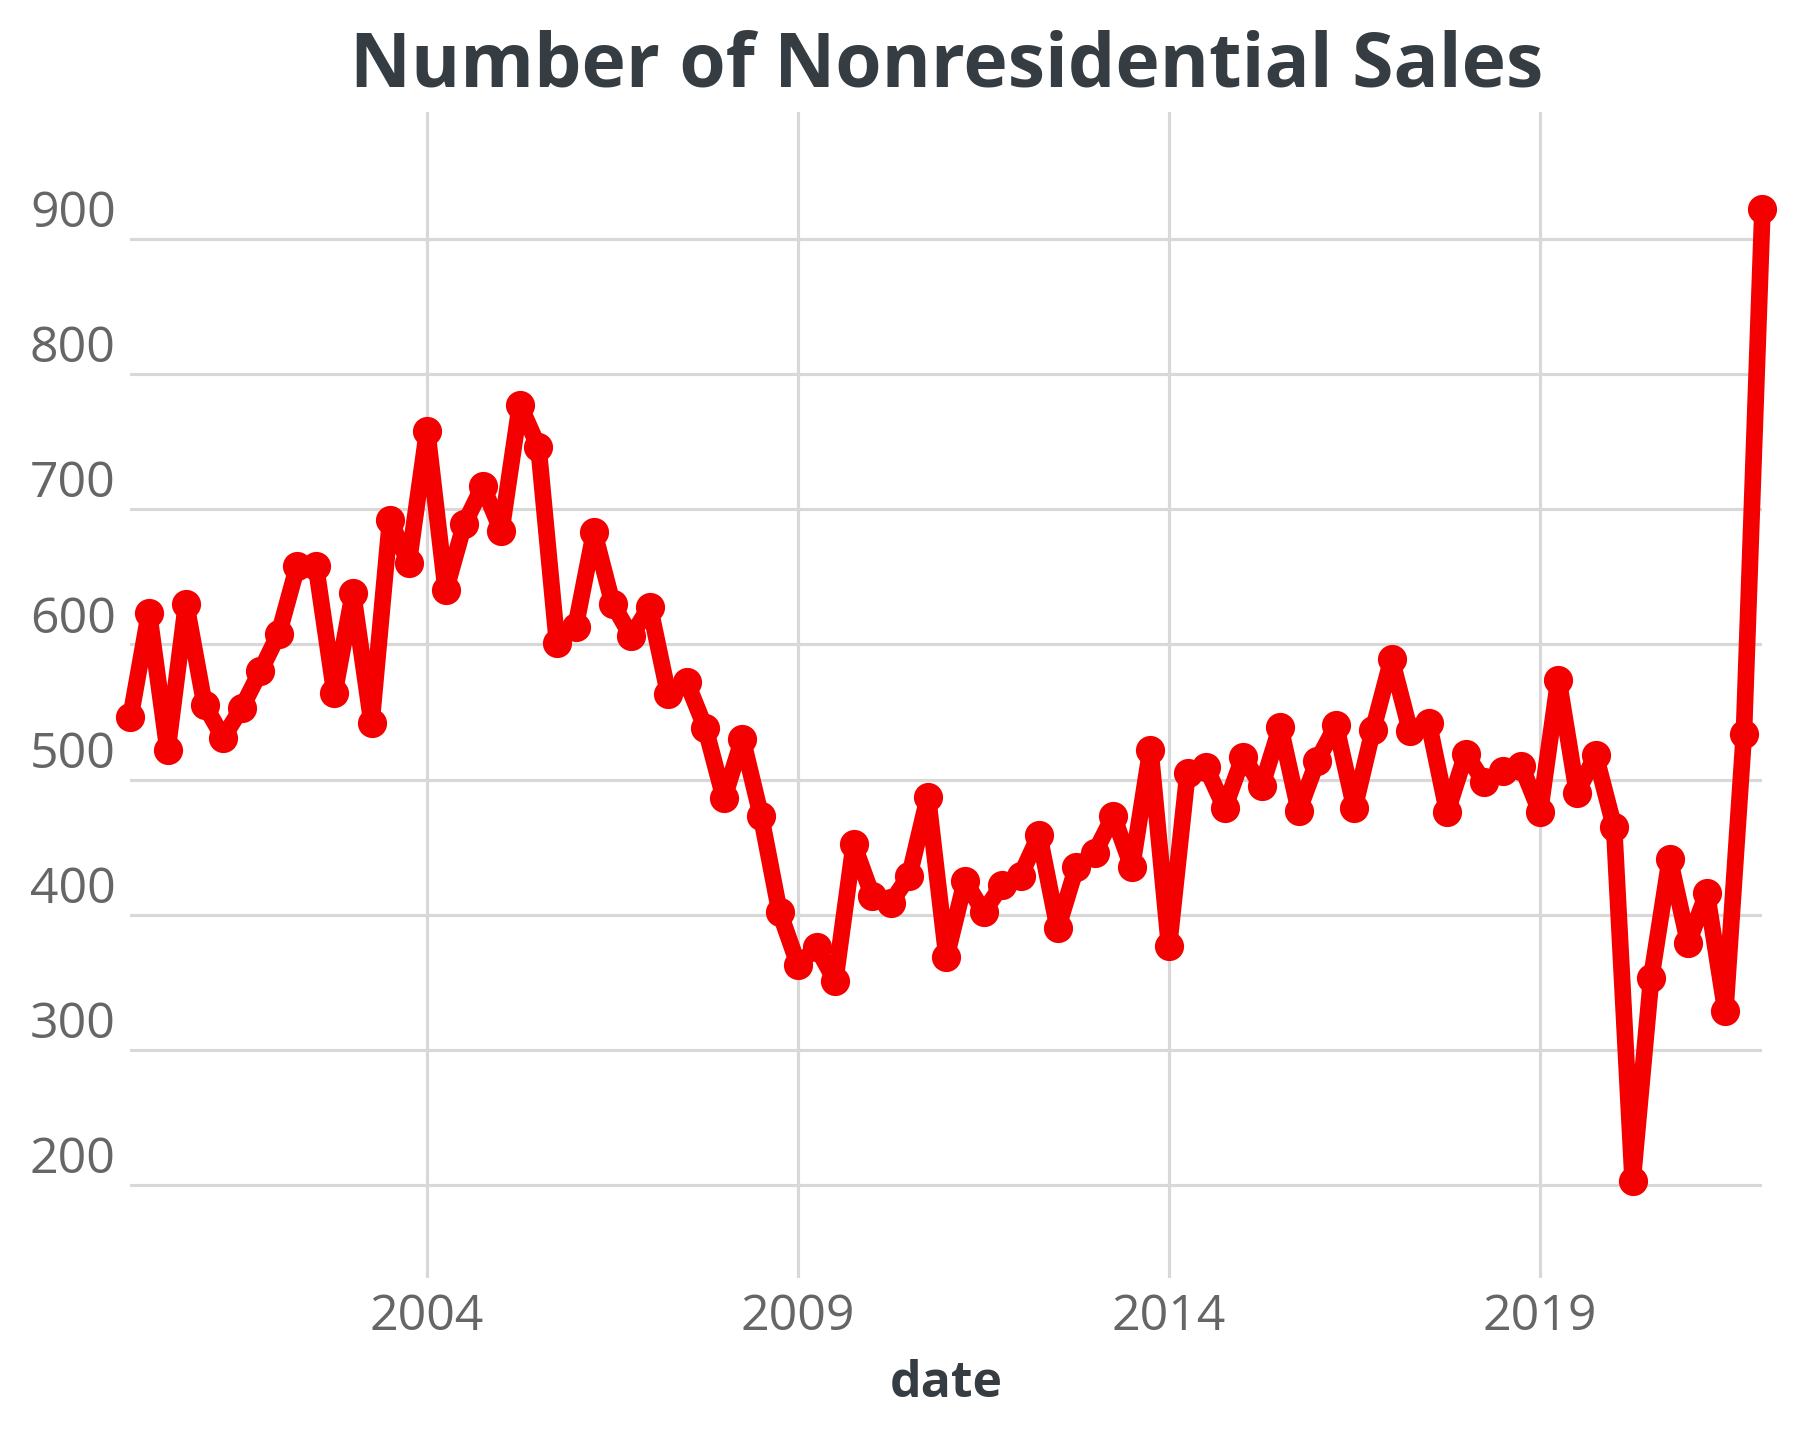

In [27]:
with plt.style.context(get_theme()):
    ax = nonres.plot(
        x="date",
        y="num_records",
        legend=False,
        clip_on=False,
        marker="o",
        color=palette["red"],
    )
    ax.set_title("Number of Nonresidential Sales")

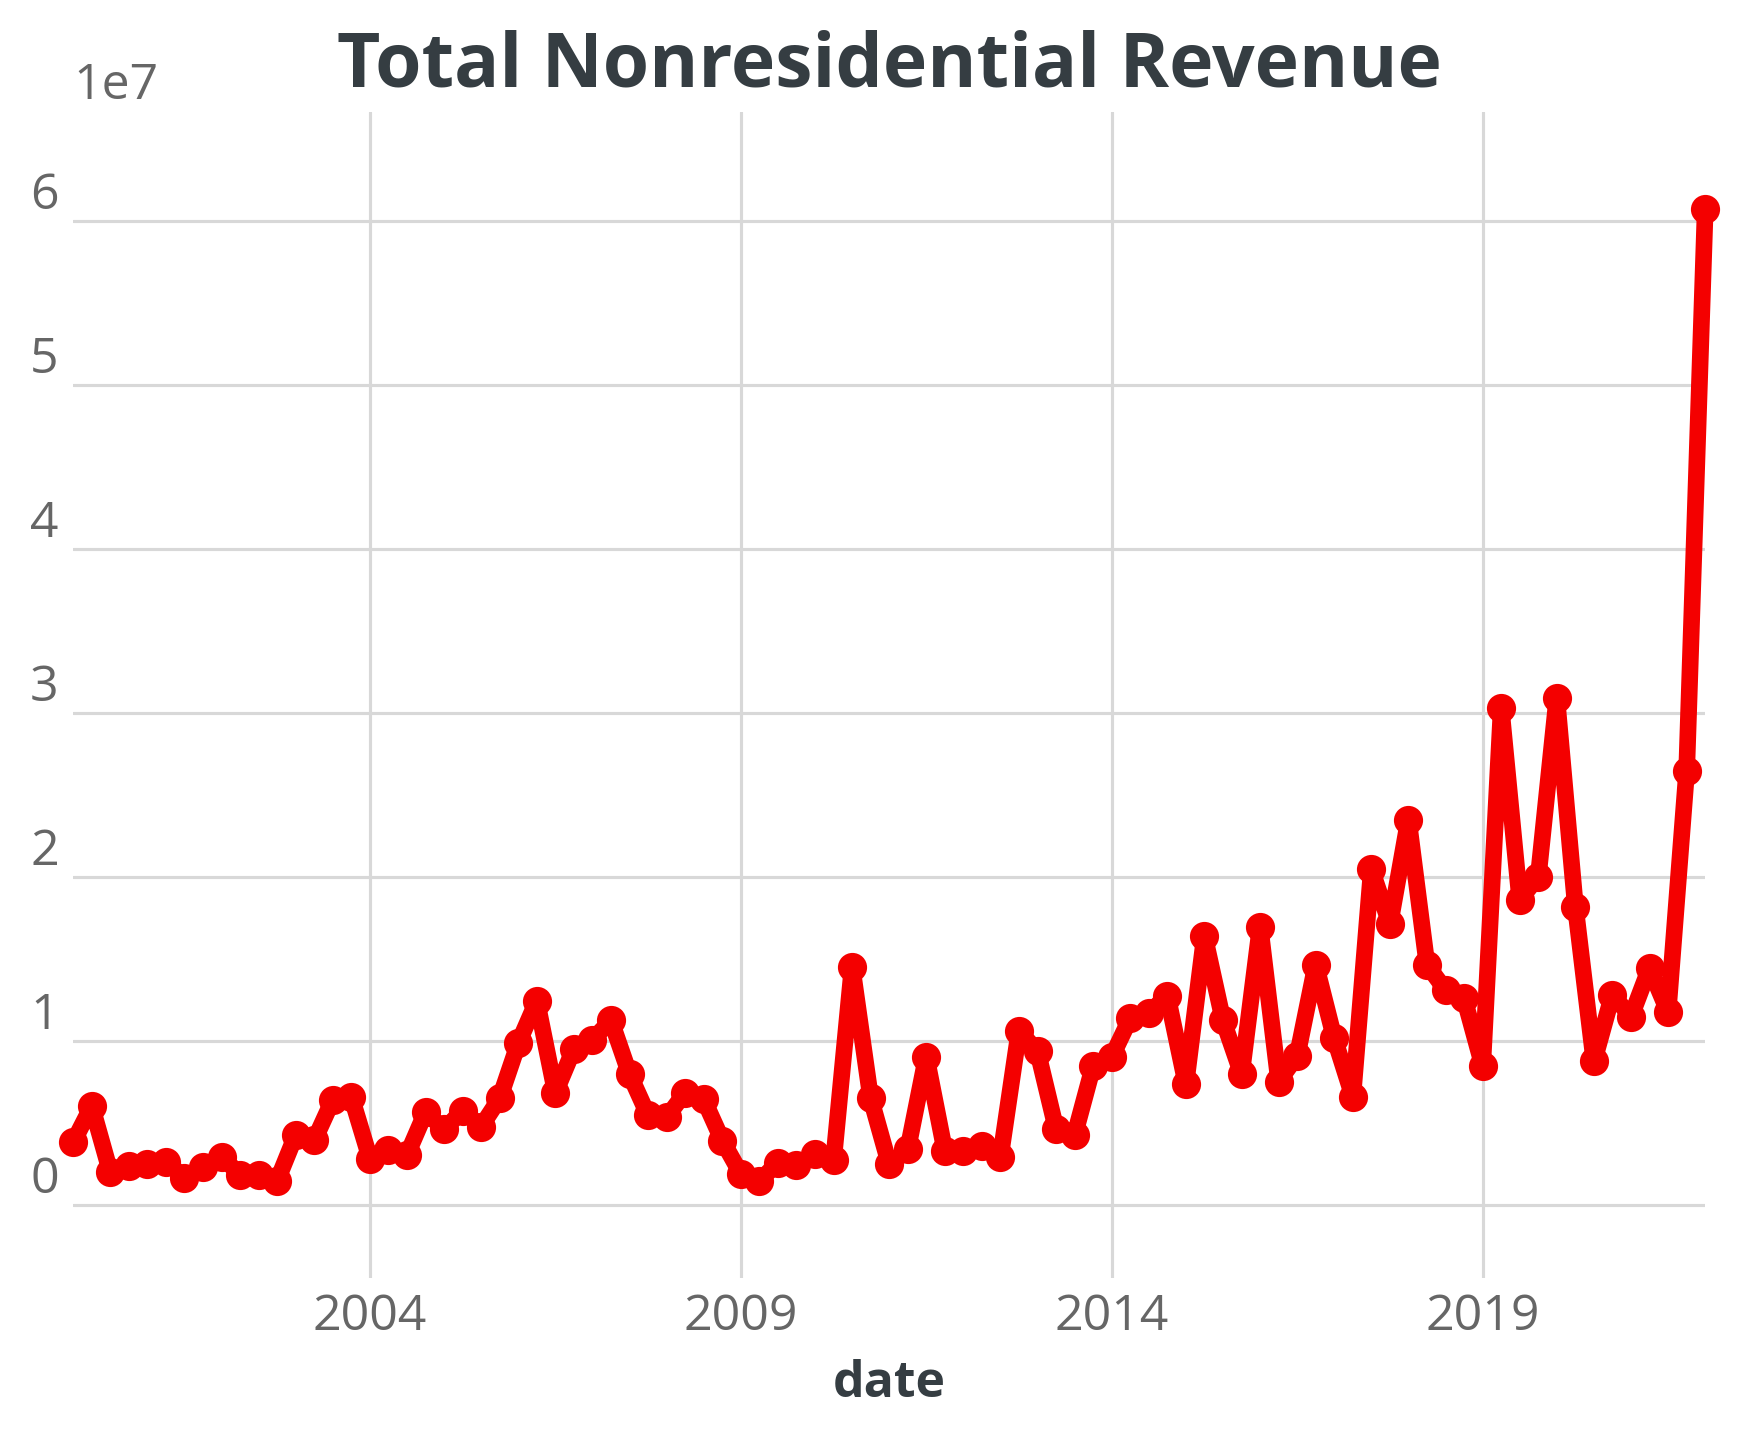

In [28]:
with plt.style.context(get_theme()):
    ax = nonres.plot(
        x="date",
        y="total",
        legend=False,
        clip_on=False,
        marker="o",
        color=palette["red"],
    )
    ax.set_title("Total Nonresidential Revenue")

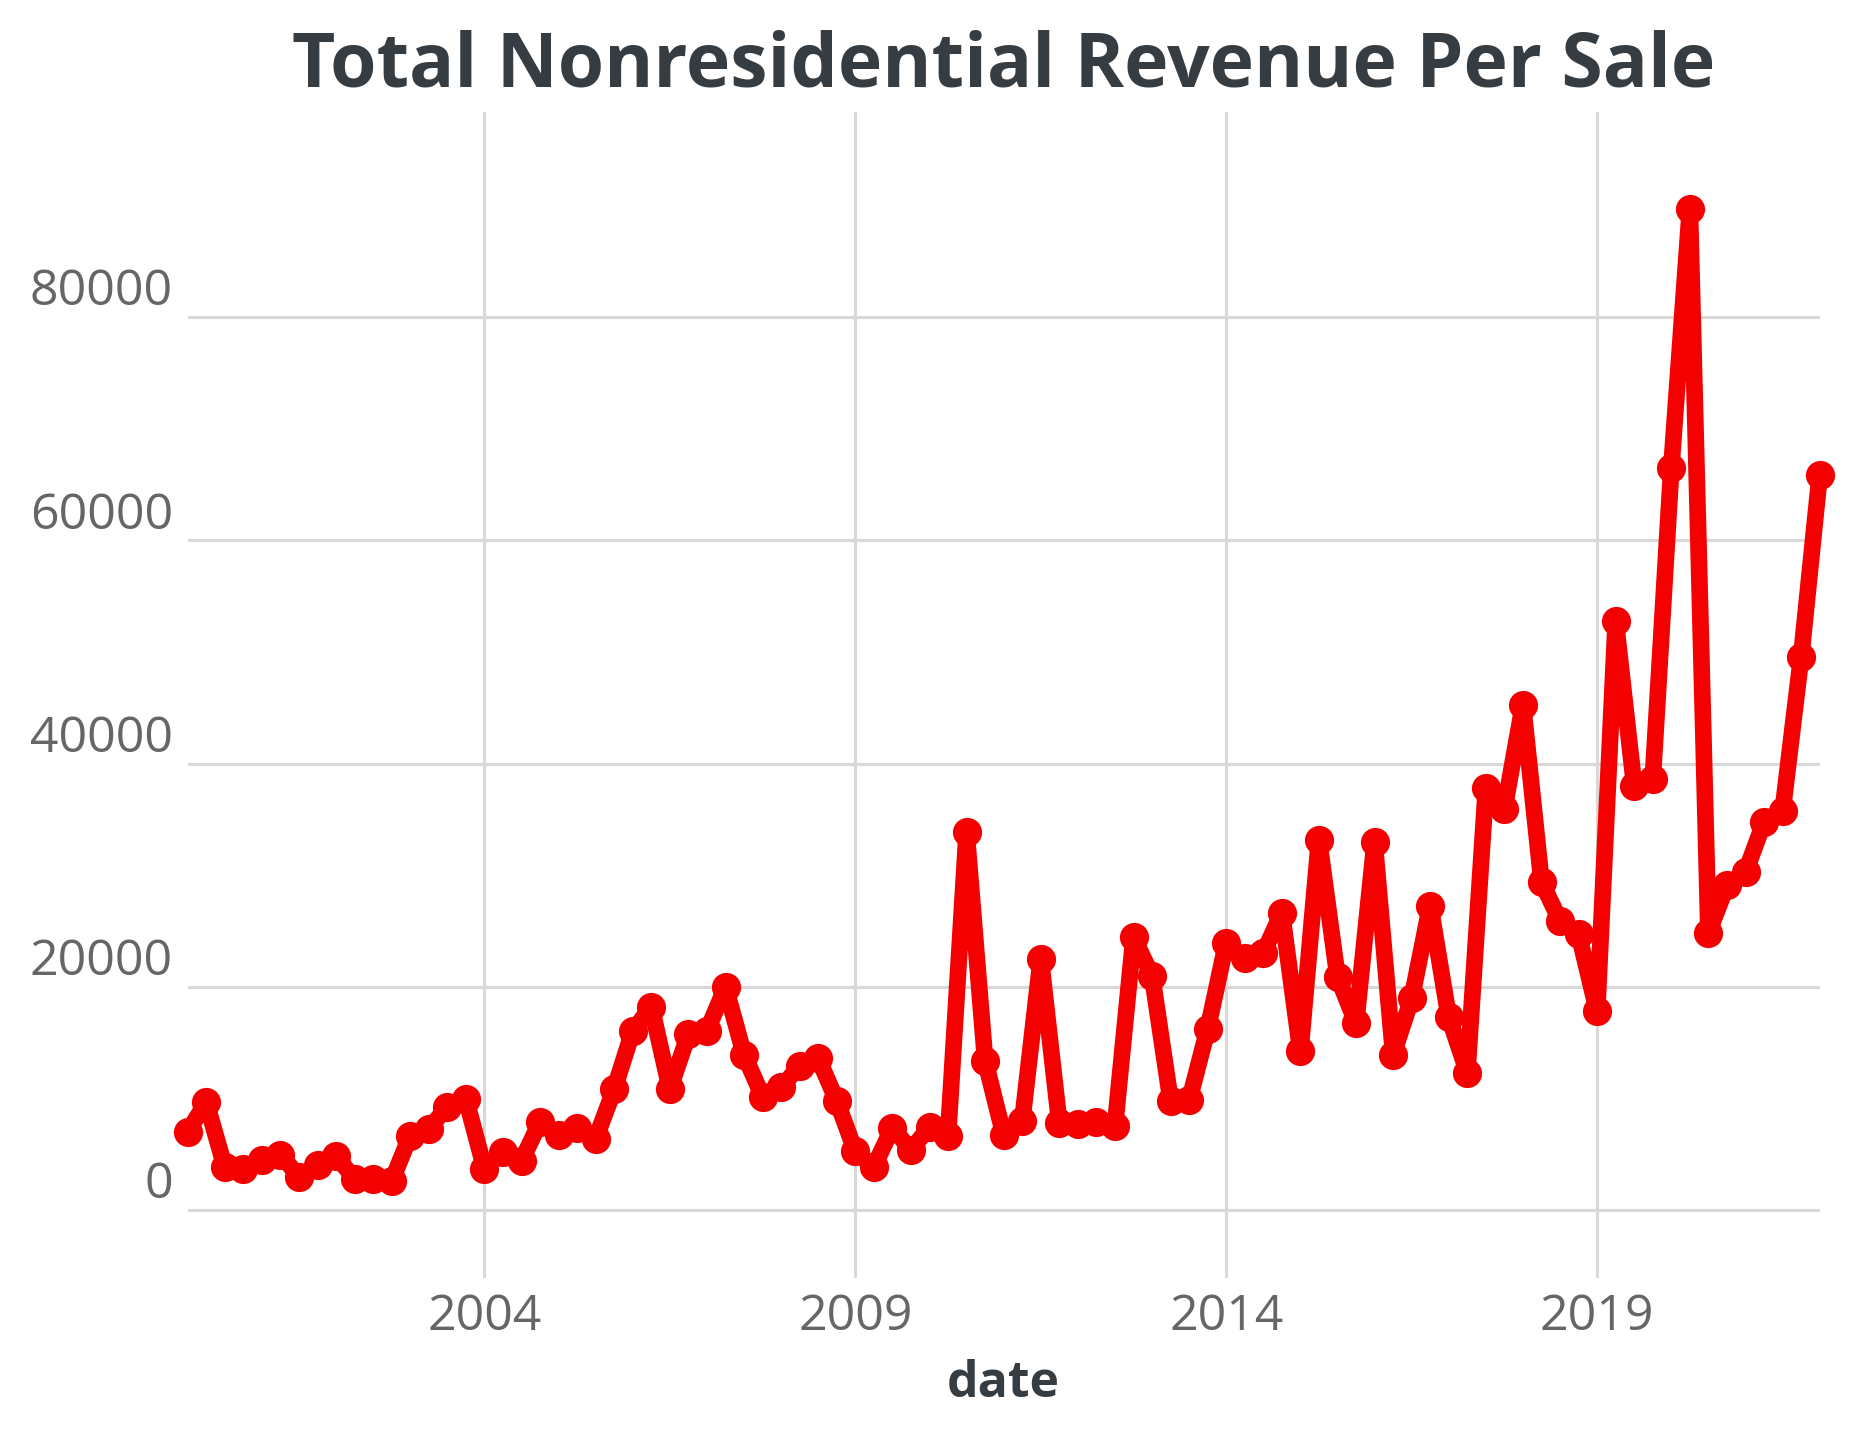

In [29]:
with plt.style.context(get_theme()):
    ax = nonres.plot(
        x="date",
        y="total_per_record",
        legend=False,
        clip_on=False,
        marker="o",
        color=palette["red"],
    )
    ax.set_title("Total Nonresidential Revenue Per Sale")

## Analysis

In [30]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

In [32]:
cbo = pd.read_csv("../../data/01_raw/cbo/2022-05-economic-projections.csv").assign(
    date=lambda df: pd.to_datetime(df.date)
)

In [34]:
# housing_starts = (
#     pd.read_csv(
#         "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=HOUST&scale=left&cosd=1959-01-01&coed=2022-05-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2022-07-08&revision_date=2022-07-08&nd=1959-01-01"
#     )
#     .rename(columns={"DATE": "date", "HOUST": "housing_starts"})
#     .assign(date=lambda df: pd.to_datetime(df.date))
#     .groupby(pd.Grouper(freq="QS", key="date"))["housing_starts"]
#     .mean()
# )
# housing_starts.loc["2022-04-01"] = 1618
# housing_starts.loc["2022-07-01"] = 1453
# housing_starts.loc["2022-10-01"] = 1388
# housing_starts.loc["2023-01-01"] = 1344
# housing_starts.loc["2023-04-01"] = 1310
# housing_starts.loc["2023-07-01"] = 1279
# housing_starts.loc["2023-10-01"] = 1245

# cbo = cbo.set_index('date')
# cbo["housing_starts"] = housing_starts
# cbo = cbo.reset_index()

In [35]:
def get_forecast(
    data,
    column,
    covid_dates={"2020-04-01": 1, "2020-07-01": 0.5, "2020-10-01": 0.25},
    abatement_dates={
        "2021-10-01": 0.5,
        "2022-01-01": 1,
        "2022-04-01": 0.5,
        "2022-07-01": 0.25,
    },
    cbo_regressor=None,
    forecast_end_date="2027-06-30",
    cap=None,
    floor=None,
    **fit_kwargs,
):
    fit_kwargs.setdefault("daily_seasonality", False)
    fit_kwargs.setdefault("weekly_seasonality", False)

    if cbo_regressor is not None:
        if isinstance(cbo_regressor, str):
            cbo_regressor = [cbo_regressor]
    else:
        cbo_regressor = []

    # Format the input data
    df = (
        data.set_index("date")[column]
        .rename_axis("ds")
        .reset_index()
        .rename(columns={column: "y"})
        .sort_values("ds")
    )
    if floor is not None:
        df['floor'] = floor
        assert cap is not None
        df['cap'] = cap

    def custom_regressor(ds, dates):
        """Custom regressor function"""
        date = ds.strftime("%Y-%m-%d")
        if date in dates:
            return dates[date]
        else:
            return 0

    def cbo_regressor_func(ds, cbo_indicator):
        """Custom regressor function"""
        if ds in cbo_indicator.index:
            return cbo_indicator.loc[ds]
        else:
            return 0

    df["covid"] = df["ds"].apply(custom_regressor, args=(covid_dates,))
    df["abatement"] = df["ds"].apply(custom_regressor, args=(abatement_dates,))

    # CBO regressor
    for col in cbo_regressor:
        df[col] = df["ds"].apply(
            cbo_regressor_func, args=(cbo.set_index("date")[col].dropna().squeeze(),)
        )

    model = Prophet(**fit_kwargs)
    model.add_regressor("covid")
    model.add_regressor("abatement")
    for col in cbo_regressor:
        model.add_regressor(col)
    model.fit(df)

    forecast_period = (
        pd.Timestamp(forecast_end_date).to_period(freq="Q")
        - df["ds"].max().to_period(freq="Q")
    ).n

    future = model.make_future_dataframe(periods=forecast_period, freq="QS")
    future["covid"] = future["ds"].apply(custom_regressor, args=(covid_dates,))
    future["abatement"] = future["ds"].apply(custom_regressor, args=(abatement_dates,))
    for col in cbo_regressor:
        future[col] = future["ds"].apply(
            cbo_regressor_func, args=(cbo.set_index("date")[col].dropna().squeeze(),)
        )
    
    if floor is not None:
        future['floor'] = floor
        future['cap'] = cap
        

    forecast = model.predict(future)
    return model, forecast

In [36]:
# Remove covid impact
sel = (res["date"].dt.year == 2020) & ((res["num_records"] <= 6500))
res_no_covid = res.loc[~sel]

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:401: Depreca


Initial log joint probability = -108.751
Iteration  1. Log joint probability =    63.8074. Improved by 172.558.
Iteration  2. Log joint probability =    118.449. Improved by 54.6419.
Iteration  3. Log joint probability =    160.099. Improved by 41.6495.
Iteration  4. Log joint probability =     160.16. Improved by 0.0611648.
Iteration  5. Log joint probability =      160.2. Improved by 0.040011.
Iteration  6. Log joint probability =     160.22. Improved by 0.0200055.
Iteration  7. Log joint probability =    160.274. Improved by 0.0540804.
Iteration  8. Log joint probability =     160.38. Improved by 0.106171.
Iteration  9. Log joint probability =    160.392. Improved by 0.0113547.
Iteration 10. Log joint probability =    160.408. Improved by 0.0168426.
Iteration 11. Log joint probability =    161.017. Improved by 0.608949.
Iteration 12. Log joint probability =    179.012. Improved by 17.9949.
Iteration 13. Log joint probability =    179.151. Improved by 0.139013.
Iteration 14. Log joi

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: Depreca

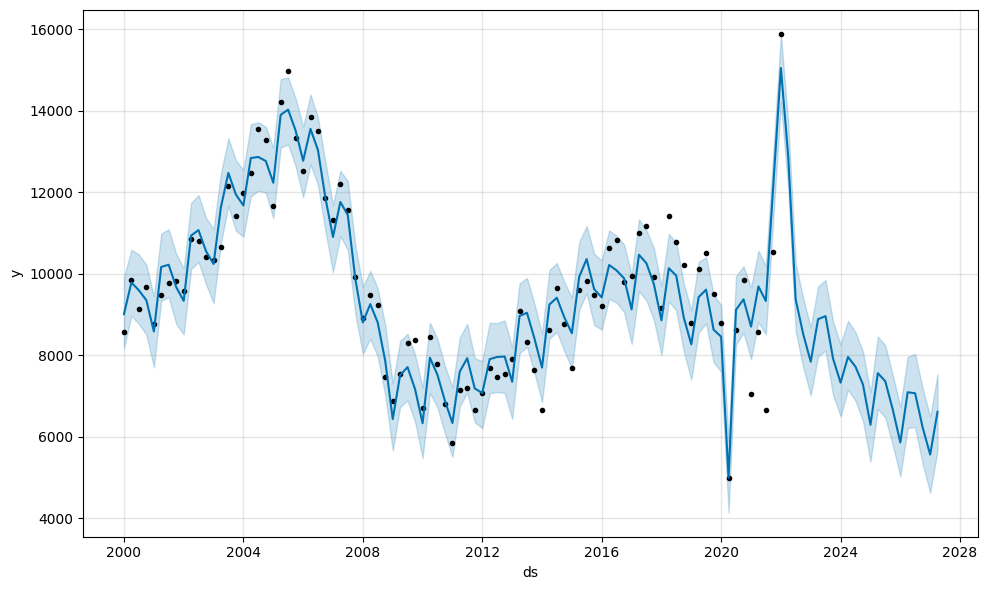

In [65]:
model, residential_sales = get_forecast(
    res,
    "num_records",
    covid_dates={
     "2020-04-01": 1,
    },
    abatement_dates={
        "2021-10-01": 0.5,
        "2022-01-01": 1,
        "2022-04-01": 0.5,
    },
    cbo_regressor="real_res_fixed_invest",
)
fig = model.plot(residential_sales)

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:401: Depreca


Initial log joint probability = -106.151
Iteration  1. Log joint probability =    18.6302. Improved by 124.782.
Iteration  2. Log joint probability =    126.885. Improved by 108.255.
Iteration  3. Log joint probability =    126.897. Improved by 0.0117472.
Iteration  4. Log joint probability =    126.942. Improved by 0.0447229.
Iteration  5. Log joint probability =    126.989. Improved by 0.0471393.
Iteration  6. Log joint probability =    127.067. Improved by 0.0786747.
Iteration  7. Log joint probability =    127.217. Improved by 0.149825.
Iteration  8. Log joint probability =    163.622. Improved by 36.4044.
Iteration  9. Log joint probability =    163.999. Improved by 0.377609.
Iteration 10. Log joint probability =    166.498. Improved by 2.49863.
Iteration 11. Log joint probability =    166.825. Improved by 0.326716.
Iteration 12. Log joint probability =    167.103. Improved by 0.278722.
Iteration 13. Log joint probability =    167.289. Improved by 0.186122.
Iteration 14. Log join

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: Depreca

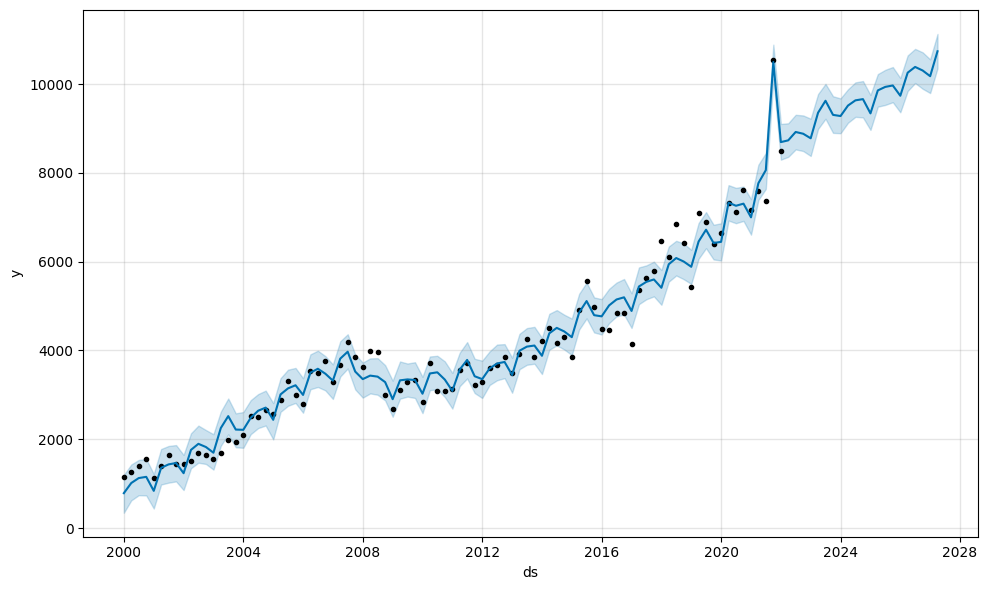

In [66]:
model, residential_prices = get_forecast(
    res,
    "total_per_record",
    cbo_regressor="house_price_index_fhfa",
    abatement_dates={
        "2021-10-01": 1,
        "2022-01-01": 0.25,
    },
)
model.plot(residential_prices);

In [67]:
R = (
    residential_prices.set_index("ds")["yhat"]
    * residential_sales.set_index("ds")["yhat"]
)

R / 1e6

ds
2000-01-01     7.084486
2000-04-01     9.934192
2000-07-01    10.806756
2000-10-01    10.788070
2001-01-01     7.196544
                ...    
2026-04-01    72.785839
2026-07-01    73.451313
2026-10-01    64.247387
2027-01-01    56.655837
2027-04-01    71.074586
Name: yhat, Length: 110, dtype: float64

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:401: Depreca


Initial log joint probability = -109.806
Iteration  1. Log joint probability =    48.0096. Improved by 157.815.
Iteration  2. Log joint probability =    108.793. Improved by 60.7835.
Iteration  3. Log joint probability =    152.356. Improved by 43.563.
Iteration  4. Log joint probability =    198.257. Improved by 45.9009.
Iteration  5. Log joint probability =    216.775. Improved by 18.518.
Iteration  6. Log joint probability =    216.991. Improved by 0.215878.
Iteration  7. Log joint probability =    217.074. Improved by 0.0836469.
Iteration  8. Log joint probability =    217.079. Improved by 0.00482549.
Iteration  9. Log joint probability =    217.672. Improved by 0.592643.
Iteration 10. Log joint probability =    217.864. Improved by 0.192646.
Iteration 11. Log joint probability =    217.881. Improved by 0.0161609.
Iteration 12. Log joint probability =    217.934. Improved by 0.0537076.
Iteration 13. Log joint probability =    217.969. Improved by 0.0349421.
Iteration 14. Log joint

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: Depreca

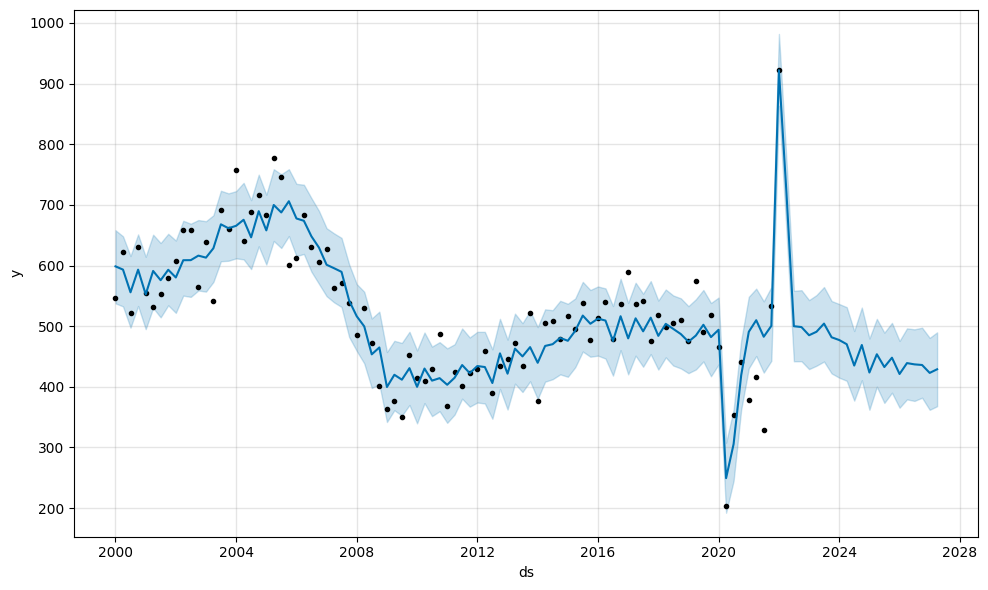

In [68]:
model, nonresidential_sales = get_forecast(
    nonres,
    "num_records",
    covid_dates={
        "2020-04-01": 1,
        "2020-07-01": 0.75,
        "2020-10-01": 0.5,
    },
    abatement_dates={
        "2022-01-01": 1,
        "2022-04-01": 0.5,
        "2022-07-01": 0.,
        "2022-10-01": 0.,
    },
    cbo_regressor="real_res_fixed_invest",
)
model.plot(nonresidential_sales);

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:401: Depreca


Initial log joint probability = -105.019
Iteration  1. Log joint probability =    43.3971. Improved by 148.416.
Iteration  2. Log joint probability =    117.451. Improved by 74.0542.
Iteration  3. Log joint probability =     117.48. Improved by 0.0290909.
Iteration  4. Log joint probability =    133.093. Improved by 15.6124.
Iteration  5. Log joint probability =    133.113. Improved by 0.0203315.
Iteration  6. Log joint probability =    148.788. Improved by 15.6747.
Iteration  7. Log joint probability =    148.985. Improved by 0.196976.
Iteration  8. Log joint probability =     149.02. Improved by 0.0354591.
Iteration  9. Log joint probability =    149.113. Improved by 0.0922815.
Iteration 10. Log joint probability =    149.166. Improved by 0.0539002.
Iteration 11. Log joint probability =    149.201. Improved by 0.0348527.
Iteration 12. Log joint probability =    149.368. Improved by 0.166297.
Iteration 13. Log joint probability =    149.561. Improved by 0.192912.
Iteration 14. Log jo

/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  .astype(np.float)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/nicholashand/Library/Caches/pypoetry/virtualenvs/fyp-analysis-ZVW_eOe5-py3.9/lib/python3.9/site-packages/fbprophet/forecaster.py:434: Depreca

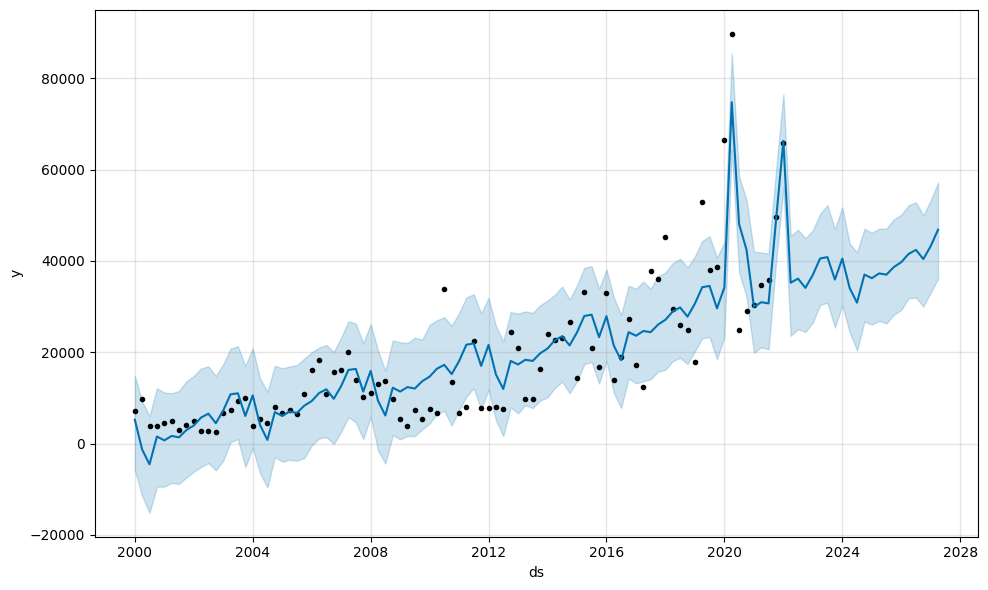

In [69]:
model, nonresidential_prices = get_forecast(
    nonres,
    "total_per_record",
    abatement_dates={
        "2021-10-01": 0.5,
        "2022-01-01": 1,
    },
    cbo_regressor=None,
    
    
)
model.plot(nonresidential_prices);

In [70]:
NR = (
    nonresidential_prices.set_index("ds")["yhat"]
    * nonresidential_sales.set_index("ds")["yhat"]
)

NR / 1e6

ds
2000-01-01     3.119219
2000-04-01    -0.777443
2000-07-01    -2.533582
2000-10-01     0.907233
2001-01-01     0.381096
                ...    
2026-04-01    18.227033
2026-07-01    18.534214
2026-10-01    17.608107
2027-01-01    18.289975
2027-04-01    20.085412
Name: yhat, Length: 110, dtype: float64

In [71]:
quarterly_revenue = R + NR

In [82]:
revenue_by_fy = aggregate_to_fiscal_year(quarterly_revenue).rename(columns={"total": TAX_BASE_COLUMN}).squeeze()

(revenue_by_fy/1e6).tail(7)

fiscal_year
2021    333.865338
2022    572.420007
2023    384.203802
2024    377.029571
2025    341.259056
2026    337.827254
2027    339.946832
Name: yhat, dtype: float64

In [87]:
tax_base_by_fy = (revenue_by_fy / this_tax.rates.set_index("fiscal_year")["rate"]).dropna().rename(TAX_BASE_COLUMN)

In [89]:
tax_base_by_fy

fiscal_year
2000    6.453484e+08
2001    1.410894e+09
2002    2.264132e+09
2003    3.393868e+09
2004    4.560036e+09
2005    5.149351e+09
2006    6.585815e+09
2007    6.671417e+09
2008    5.677866e+09
2009    3.926619e+09
2010    4.010220e+09
2011    4.193465e+09
2012    4.648823e+09
2013    4.979826e+09
2014    5.967927e+09
2015    7.122147e+09
2016    8.229037e+09
2017    8.202543e+09
2018    8.798581e+09
2019    8.637274e+09
2020    8.490860e+09
2021    1.018503e+10
2022    1.746248e+10
2023    1.172068e+10
2024    1.150182e+10
2025    1.041059e+10
2026    1.030590e+10
2027    1.037056e+10
Name: RTTBase, dtype: float64

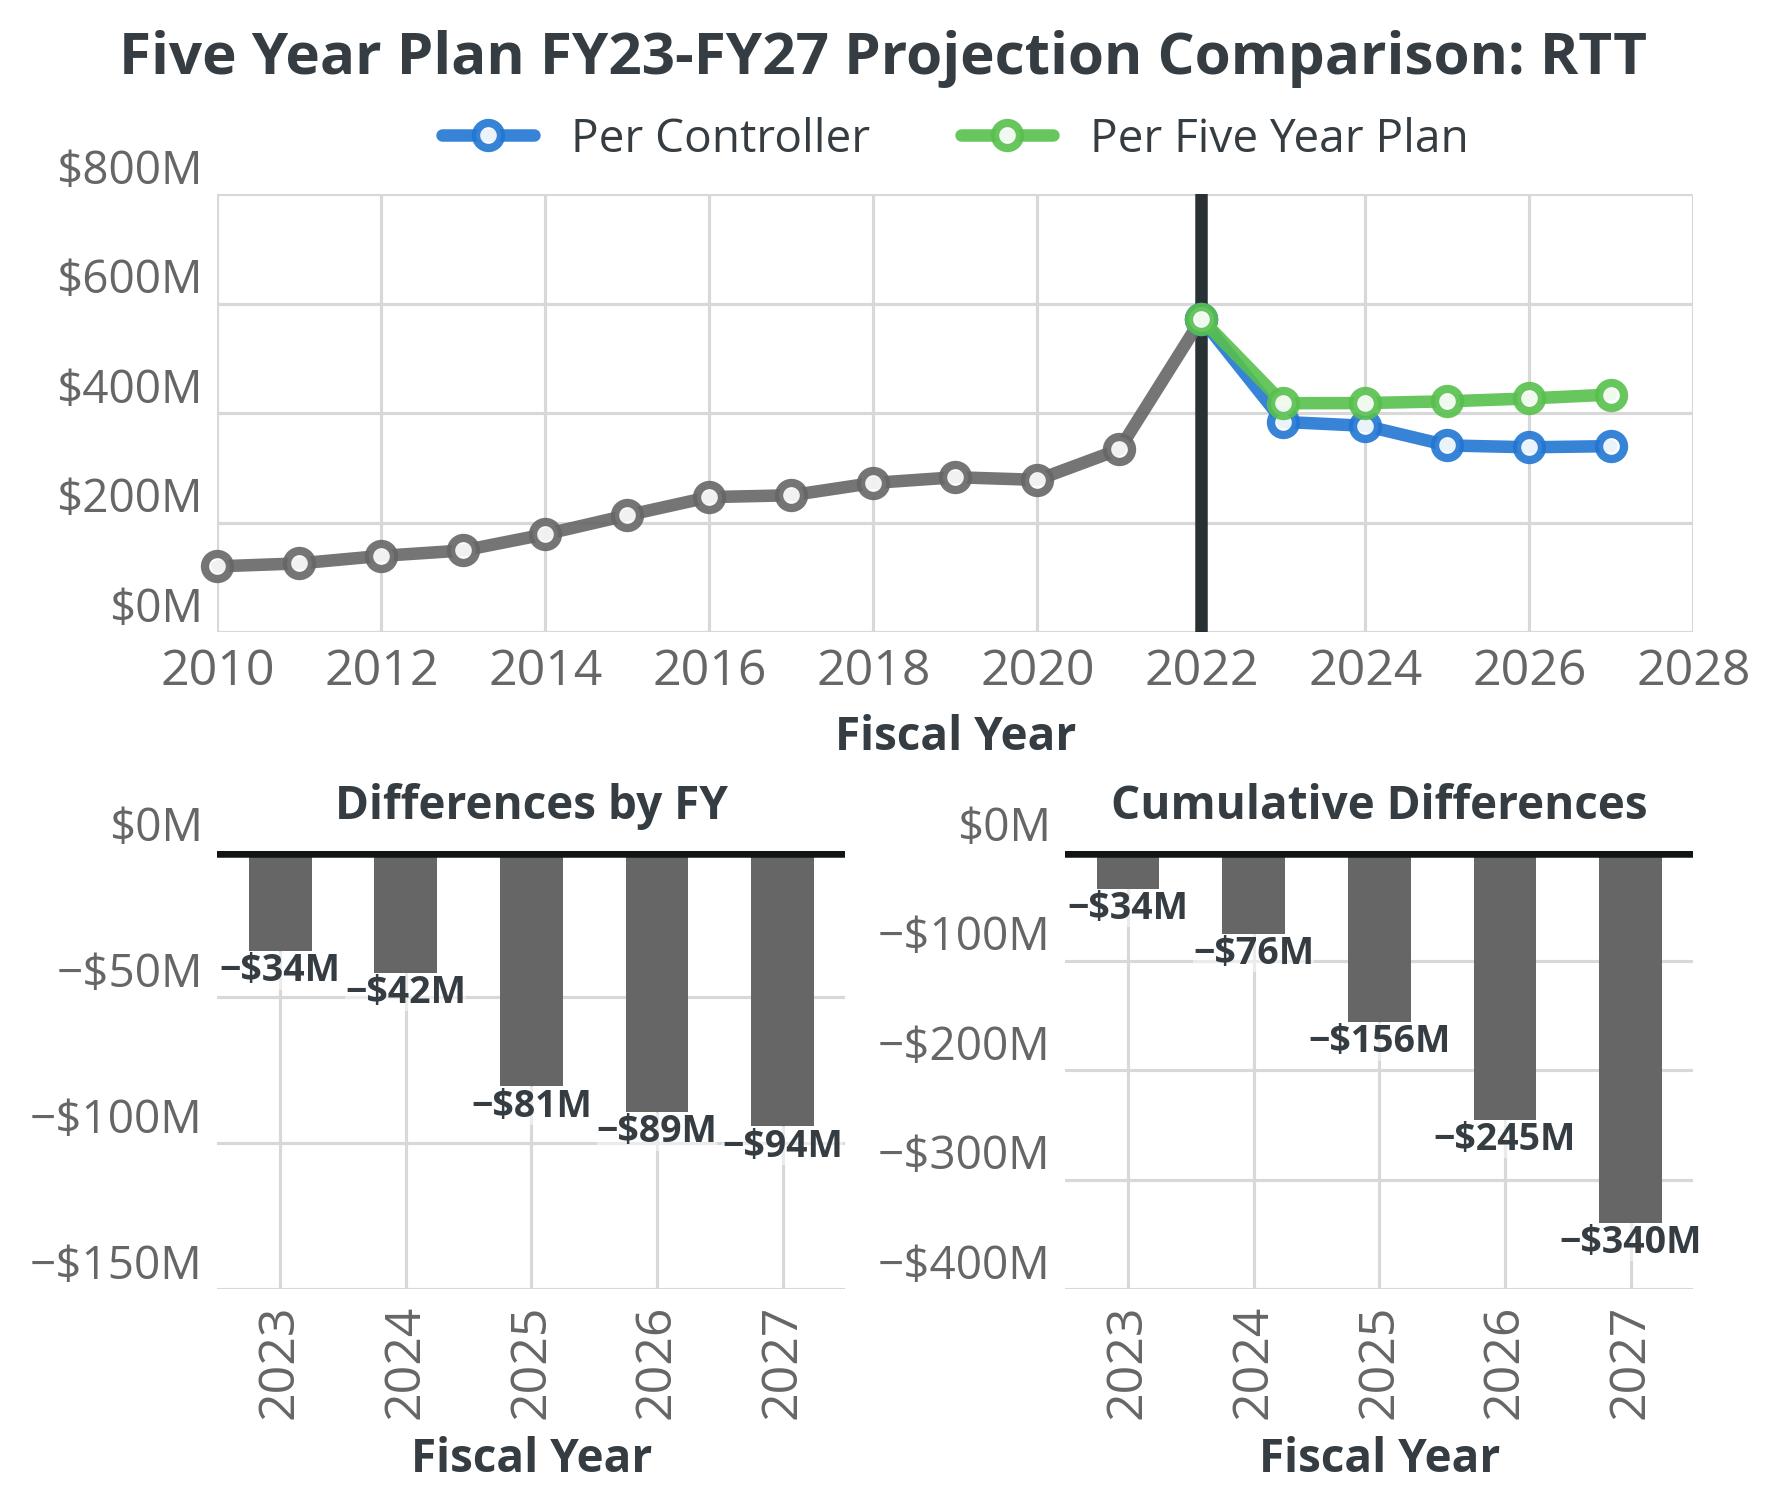

In [88]:
plot_projection_comparison(this_tax, tax_base_by_fy);

In [93]:
DATA.save("rtt_tax_base_forecast", tax_base_by_fy)

2022-07-08 13:36:56,083 - kedro.io.data_catalog - INFO - Saving data to `rtt_tax_base_forecast` (CSVDataSet)...
